<a href="https://colab.research.google.com/github/tateemma/Audio-classification-using-CNN/blob/master/Audio_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Credits:** This was achieved through the help of Dr. Emmanuel Dufourq, for a presentation in his Data Science class.

## Imports

In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from os import listdir
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D,  MaxPooling2D 
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.callbacks import ModelCheckpoint
import IPython.display as ipd

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

%tensorflow_version 1.x
import tensorflow as tf
#print(tf.__version__)

TensorFlow is already loaded. Please restart the runtime to change versions.


## Authenticate to your Google Drive

In [272]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Download the archive file which will be uncompressed to your Drive

This snippet of code will uncompress the files into a temporary folder location. In this case it is called `local_location`. We need to be consistent with names as when reading the data we will need to specify this folder name.

In [273]:
myzip = drive.CreateFile({'id': '1wKDQrkcMGpEmGh_14Itja3ZkR7OX38s2'})
myzip.GetContentFile('Archive.zip')

print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('Archive.zip', 'r')
zip_ref.extractall('local_location/')

Uncompressing zip file


## Function to extract features and targets from a directory

In [274]:
def extract_data_from_multiple_files(directory, label):
    
    # Directory listing
    file_names = load_data(directory)
    
    # Create empty list to store features and target
    X = []
    Y = []
    
    num_files = len(file_names)
    
    # Iterate over the .wav files
    for idx, file in enumerate(file_names):

        if idx%100 == 0:
            print (str(idx)+str(' files read out of ') + str(num_files))
            
        # Extract data from one audio file
        data, sample_rate = librosa.load(directory+file)
        
        if len(data) == 22050:
        
            # Append the features and target
            X.append(data)
            Y.append(label)
        
    # Return the features and target as a Numpy array
    return np.array(X), np.array(Y)

## Function to get a list of .wav files

This function gets a list of all the files containing '.wav' in the file name.

In [275]:
def load_data(directory):
    
    file_names = []
    
    # Iterate through each file in the directory
    for file in listdir(directory):
        # Check file name contains .wav
        if '.wav' in file:
            # Append the file name
            file_names.append(file)
            
    return file_names

In [276]:
listdir('local_location')

['bird', 'dog', 'on', '__MACOSX', 'off']

## Load all the `dog` files into memory

Roughly 6.5 minute operation

In [277]:
X_dog, Y_dog = extract_data_from_multiple_files('local_location/dog/', 'dog')

0 files read out of 1746
100 files read out of 1746
200 files read out of 1746
300 files read out of 1746
400 files read out of 1746
500 files read out of 1746
600 files read out of 1746
700 files read out of 1746
800 files read out of 1746
900 files read out of 1746
1000 files read out of 1746
1100 files read out of 1746
1200 files read out of 1746
1300 files read out of 1746
1400 files read out of 1746
1500 files read out of 1746
1600 files read out of 1746
1700 files read out of 1746


## Load all the `bird` files into memory

Roughly 5 minute operation

In [278]:
X_bird, Y_bird = extract_data_from_multiple_files('local_location/bird/', 'bird')

0 files read out of 1731
100 files read out of 1731
200 files read out of 1731
300 files read out of 1731
400 files read out of 1731
500 files read out of 1731
600 files read out of 1731
700 files read out of 1731
800 files read out of 1731
900 files read out of 1731
1000 files read out of 1731
1100 files read out of 1731
1200 files read out of 1731
1300 files read out of 1731
1400 files read out of 1731
1500 files read out of 1731
1600 files read out of 1731
1700 files read out of 1731


## Create X and Y variables

In [279]:
X_audio = np.concatenate([X_dog, X_bird])

In [280]:
Y_audio = np.concatenate([Y_dog, Y_bird])

## Check shape

In [281]:
X_audio.shape

(3068, 22050)

In [282]:
Y_audio.shape

(3068,)

### View one audio before converting to spectrogram

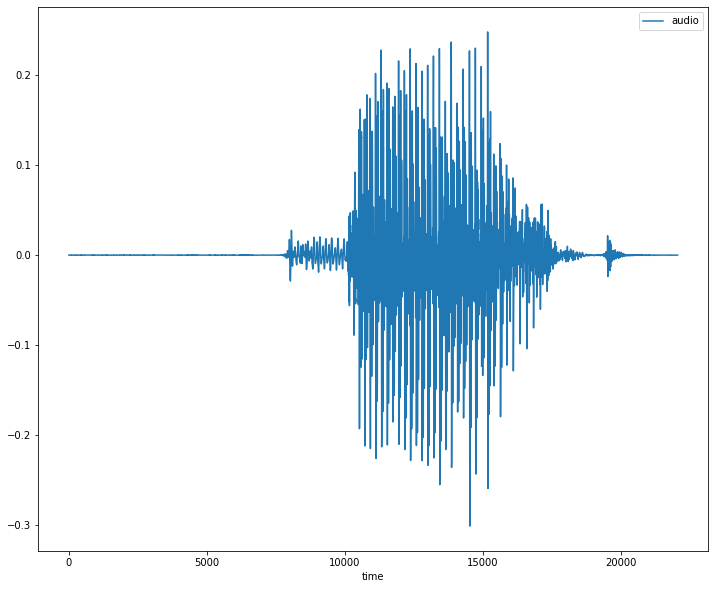

In [283]:
plt.figure(figsize=[12,10])
plt.plot(X_audio[2], label = 'audio')
plt.xlabel('time')
plt.legend()
plt.show()

## Function to convert to spectograms

In [284]:
def to_spectogram(arr):
    result = []
    n_fft = 1024
    hop_length = 256
    n_mels = 128
    f_min = 1
    f_max = 200
    for audio in arr:
        audio_data = audio
        S = librosa.feature.melspectrogram(audio_data, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, sr=22050, power=1.0)
        result.append(S)
    return np.asarray(result)

## Convert to spectogram

In [285]:
X = to_spectogram(X_audio)


In [286]:
X[1]

array([[2.32544456e-03, 2.72360039e-03, 4.11621309e-03, ...,
        5.46527729e-03, 1.25402567e-02, 2.76845667e-02],
       [3.21537979e-03, 6.96963749e-03, 6.48510106e-03, ...,
        1.13412359e-02, 1.11483232e-02, 2.84082312e-02],
       [3.76729100e-03, 8.79417494e-03, 8.13232321e-03, ...,
        1.36855477e-02, 1.65512174e-02, 3.80918482e-02],
       ...,
       [1.91557317e-05, 9.57779616e-06, 3.18575717e-10, ...,
        5.57009058e-09, 1.14142413e-04, 2.82835264e-04],
       [1.89228813e-05, 9.46137332e-06, 3.35173024e-10, ...,
        4.07747334e-09, 1.12505953e-04, 2.78780114e-04],
       [1.87760773e-05, 9.38797389e-06, 4.20877338e-10, ...,
        4.59671549e-09, 1.11484572e-04, 2.76249222e-04]])

## View X after changing to spectograms

In [287]:
X[2].shape

(128, 87)

In [288]:
type(X)

numpy.ndarray

In [289]:
X.shape

(3068, 128, 87)

## Plot sample spectograms

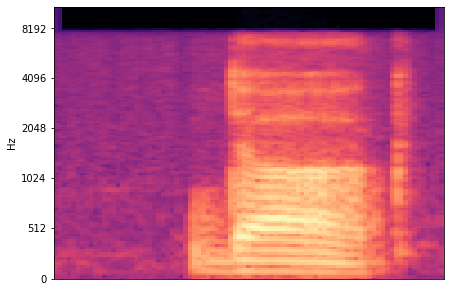

In [290]:
plt.figure(figsize=[7,5])
ax = plt.axes()
librosa.display.specshow(librosa.power_to_db(X[2]),y_axis='mel')
plt.show()

## Convert Y values using one-hot encoding

First we need to convert the Y values into integers.

In [291]:
vocab, inv = np.unique(Y_audio, return_inverse=True)

In [292]:
vocab

array(['bird', 'dog'], dtype='<U4')

In [293]:
Y = to_categorical(inv)

## Reshape X values
Keras wants to know the depth of the spectrum, i.e. it wants the format of the data as follows: [batches, width, height, depth].

In [294]:
X = np.reshape(X, (X.shape[0],X.shape[1],X.shape[2],1))

In [295]:
Y = to_categorical(inv)

## Check shape

In [296]:
X.shape

(3068, 128, 87, 1)

In [297]:
Y.shape

(3068, 2)

## Split into training, validation and testing

In [298]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.35, random_state=42, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

## Check shape

In [299]:
print ('X_train:',X_train.shape)
print ('Y_train:',Y_train.shape)
print ()
print ('X_val:',X_val.shape)
print ('Y_val:',Y_val.shape)
print ()
print ('X_test:',X_test.shape)
print ('Y_test:',Y_test.shape)

X_train: (1395, 128, 87, 1)
Y_train: (1395, 2)

X_val: (599, 128, 87, 1)
Y_val: (599, 2)

X_test: (1074, 128, 87, 1)
Y_test: (1074, 2)


## Define a model

In [300]:
def model():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu', input_shape=(128, 87, 1))) 
    
    model.add(MaxPooling2D(pool_size=2))

    model.add(Dropout(rate = 0.8))
    
    model.add(Flatten())
    
    model.add(Dense(50, activation='relu'))
    
    model.add(Dropout(rate = 0.8))
    
    model.add(Dense(2, activation='softmax'))
    
    return model

In [301]:
model = model()

## Compile

In [302]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

## Print out the model summary

In [303]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 85, 32)       320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 42, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 63, 42, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 84672)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                4233650   
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

## Create checkpoint

Here we create a checkpoint so that Keras will save the weights of the next best model. In this case, an improvement in validation accuracy is what it will consider as next best.

In [304]:
filepath="weights.best"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Train the model

Notice here, we can specify a class balance!

In [305]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
          batch_size=4,
          epochs=20,
          verbose=1, 
          callbacks=callbacks_list,
          class_weight={0:1.,1:1.0})

Epoch 1/20
345/349 [============================>.] - ETA: 0s - loss: 0.5910 - accuracy: 0.7167
Epoch 00001: val_accuracy improved from -inf to 0.91987, saving model to weights.best
INFO:tensorflow:Assets written to: weights.best/assets
349/349 [==============================] - 3s 7ms/step - loss: 0.5875 - accuracy: 0.7176 - val_loss: 0.3167 - val_accuracy: 0.9199
Epoch 2/20
343/349 [============================>.] - ETA: 0s - loss: 0.3778 - accuracy: 0.8630
Epoch 00002: val_accuracy improved from 0.91987 to 0.95659, saving model to weights.best
INFO:tensorflow:Assets written to: weights.best/assets
349/349 [==============================] - 2s 7ms/step - loss: 0.3761 - accuracy: 0.8631 - val_loss: 0.2587 - val_accuracy: 0.9566
Epoch 3/20
345/349 [============================>.] - ETA: 0s - loss: 0.3600 - accuracy: 0.8797
Epoch 00003: val_accuracy did not improve from 0.95659
349/349 [==============================] - 2s 5ms/step - loss: 0.3589 - accuracy: 0.8796 - val_loss: 0.2787 - 

## Load the weights of the best model

In [306]:
model.load_weights('weights.best/variables/variables')

## Evaluating the model

On data that was not used during training

In [307]:
prediction_classes_test = model.predict_classes(X_test)

## The confusion matrix

In [308]:
confusion_matrix(np.argmax(Y_test,1), prediction_classes_test)

array([[500,  20],
       [ 40, 514]])

## Predicting on validation data

In [309]:
prediction_classes_val = model.predict_classes(X_val)

In [310]:
# view predicted classes
prediction_classes_val[0:10]

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 1])

## Predicting on training data

In [311]:
prediction_classes_train = model.predict_classes(X_train)

## Computing the accuracy


In [312]:
test_accuracy = accuracy_score(np.argmax(Y_test,1), prediction_classes_test)
train_accuracy = accuracy_score(np.argmax(Y_train,1), prediction_classes_train)
val_accuracy = accuracy_score(np.argmax(Y_val,1), prediction_classes_val)
print(test_accuracy, train_accuracy, val_accuracy)

0.9441340782122905 0.9720430107526882 0.9649415692821369


## Plotting the performance


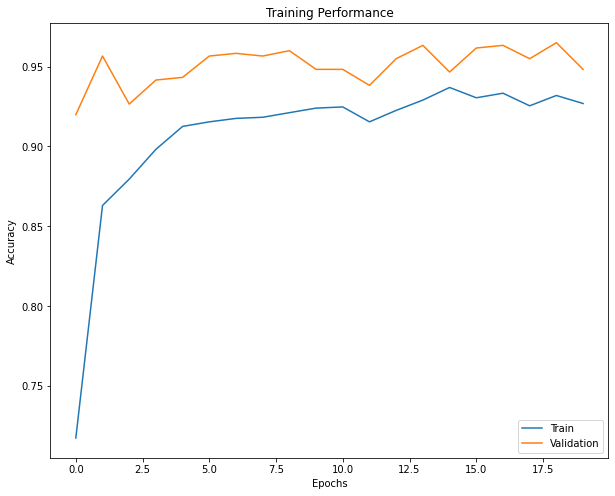

In [313]:
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10, 8]
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='best')

plt.draw()
plt.show()